# Example using Kriging to Interpolate Demand Between Citi Bike Stations

The R-code used to perform kriging is based on this blog post: https://rpubs.com/nabilabd/118172

### View the data

Here we have a GeoDataFrame in which each row is a single CitiBike station, and `trip_starts` is the number of trips which started at that station.

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [17]:
gdf = gpd.read_file("citibike_station_trip_starts.geojson")

In [18]:
gdf.head(2)

,id,lon,lat,trip_starts,x,y,geometry
0,72,-73.993929,40.767272,889,-7.139399e+06,4.782065e+06,POINT (-7139398.959 4782064.524)
1,79,-74.006667,40.719116,528,-7.140628e+06,4.777383e+06,POINT (-7140627.975 4777383.286)


The GeoJSON file is in EPSG:6933, meaning that the point geometries are in meters.

In [19]:
gdf.crs

<Derived Projected CRS: EPSG:6933>
Name: WGS 84 / NSIDC EASE-Grid 2.0 Global
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 86°S and 86°N.
- bounds: (-180.0, -86.0, 180.0, 86.0)
Coordinate Operation:
- name: US NSIDC EASE-Grid 2.0 Global
- method: Lambert Cylindrical Equal Area
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We can plot the data using number of trip starts to drive the dot size:

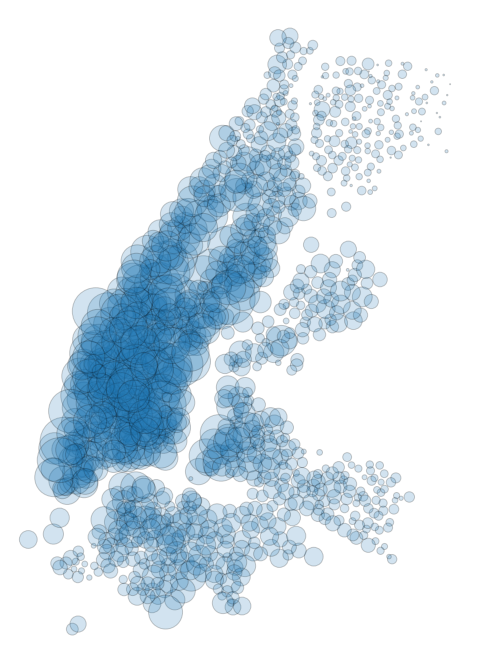

In [20]:
fig, ax = plt.subplots(figsize=(20,12))
gdf.plot(markersize=gdf['trip_starts'], edgecolor='black', alpha=0.2, ax=ax)
ax.axis('off');

## Perform Kriging on Citibike Trips using R

The idea is to estimate demand for CitiBike trip starts, interpolating between stations so that we have a smooth surface which fills in the gaps.

R seems to have better libraries for kriging than Python. So let's do this in R.

Enable R within this notebook using rpy2:

In [21]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Load the necessary R spatial libraries:

In [22]:
%%R
library(sp)
library(sf)
library(gstat)

Read the data into a SpatialPoints object in R. Remember that this file is already in EPSG:6933

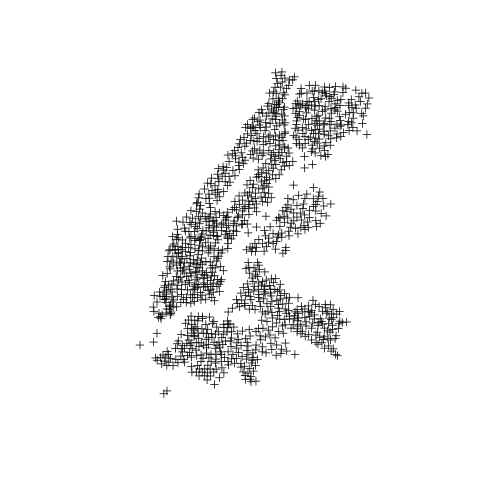

In [23]:
%%R
stations <- read_sf('citibike_station_trip_starts.geojson')
stations <- as_Spatial(stations)
plot(stations)

Make a grid over the points. Set the cell size using the `cellsize` parameter, currently set to 150 meters (since our data is in meters).

This grid is what defines the resolution of the estimates that we generate through Kriging.

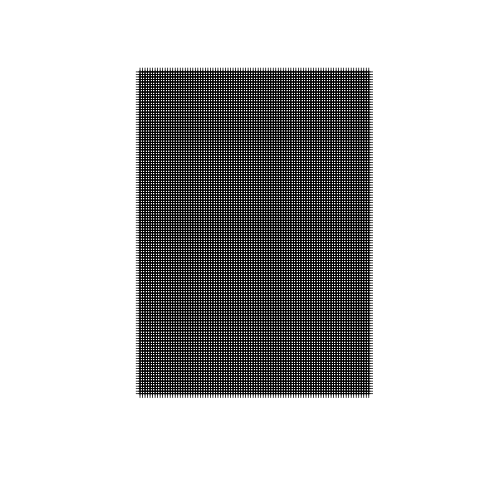

In [24]:
%%R
stations.grid <- makegrid(stations, cellsize = 150) # cell size in map projection units
stations.grid <- as_Spatial(st_as_sf(stations.grid, coords = c("x1", "x2"), crs = 6933, agr = "constant"))
plot(stations.grid)

Fit a variogram with `trip_starts` as the target variable. Set the range to 1000 meters.

In [25]:
%%R
stations.vgm <- variogram(trip_starts~1, stations)
stations.fit <- fit.variogram(stations.vgm, model=vgm(1, "Lin", 1000, 1))

Use kriging to make predictions, interplating between stations to points on our grid.

In [26]:
%%R
stations.kriged <- st_as_sf(krige(trip_starts ~ 1, stations, stations.grid, model=stations.fit))

[using ordinary kriging]


Plot the kriging results.

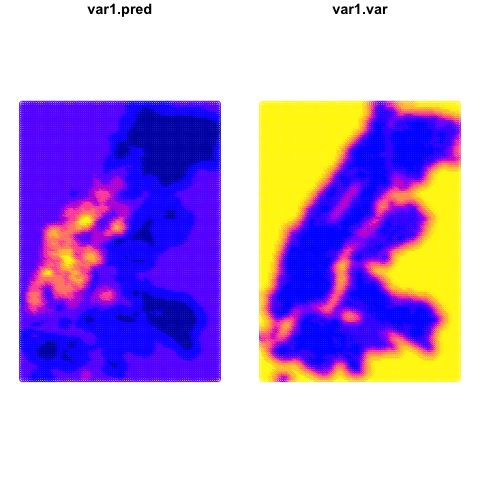

In [27]:
%%R
plot(stations.kriged)

Save the kriging results to a local GeoJSON.

In [28]:
%%R
st_write(stations.kriged, "kriging_results.geojson")

Writing layer `kriging_results' to data source 
  `kriging_results.geojson' using driver `GeoJSON'
Writing 11868 features with 2 fields and geometry type Point.
